<a href="https://colab.research.google.com/github/VaibhavR27/ece529/blob/main/Project_03_Rathore_Vaibhav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 529/629 - Project 3

# Name: ___Vaibhav Rathore___
## Traffic Sign Dataset

This dataset is from https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

**Please download the dataset from Kaggle to the datasets/traffic_signs folder before running this notebook.**

The import functions are from https://www.kaggle.com/akrsnv/gtsrb-classification-with-vgg-19

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import csv
import numpy as np
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical

import pandas as pd

The following shows the 43 classes of the dataset. The image is the idealized representation of the street sign.

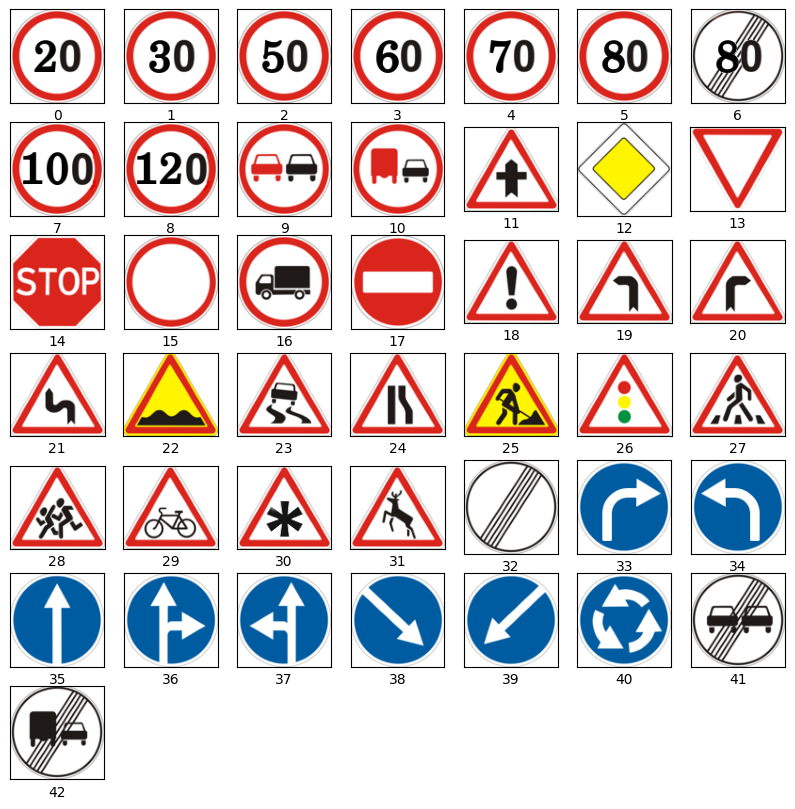

In [3]:
dir = './drive/MyDrive/traffic_signs_1'

plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dir + "/Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

The following code loads the dataset from disk into memory. In addition, the 3 color values of each image (red, green blue) are scaled to 0..1. The shape of each image is 50 x 50 with 3 color values. The classification data is represented with one-hot encoding.

In [4]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            if image is None:
                print(f"Warning: failed to load {os.path.join(cur_path, file_name)}")
                continue  # skip this image
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            if image is None:
                print(f"Warning: failed to load {os.path.join(path, rows[7])}")
                continue  # skip this image
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [5]:
train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)


(50, 50, 3)


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (31367, 50, 50, 3)
X_valid.shape (7842, 50, 50, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


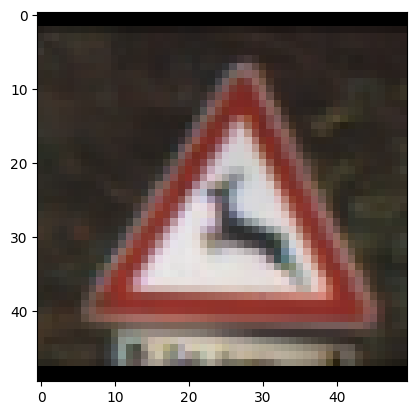

In [7]:
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

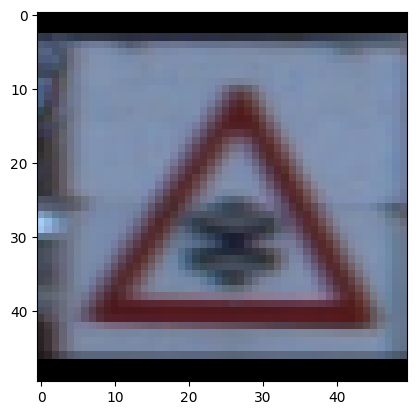

In [9]:
plt.imshow(cv2.cvtColor(X_train[30000], cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
y_train[30000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Part 1: Model Structure

The following code shows the configuration and training of a straightforward 3-layer model. You can reuse this code block throughout the assignment and simply change the various aspects under consideration.

**NOTE:** It is important that you clear the session whenever you train a different model to be able to compare them. Otherwise, Keras will continue training the model it has been working on, which might lead to confusing results.

Since training can take some time, we initially train with just a small number of epochs. You can adjust this variable as you like. Larger values will require more processing time. In Part 5, we will take our model and train for a long time.

In [11]:
epochs = 5

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1030 - loss: 3.4924 - val_accuracy: 0.2122 - val_loss: 3.1857
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2468 - loss: 3.0995 - val_accuracy: 0.3196 - val_loss: 2.8808
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3403 - loss: 2.8033 - val_accuracy: 0.4156 - val_loss: 2.6235
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4186 - loss: 2.5561 - val_accuracy: 0.4596 - val_loss: 2.4137
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4622 - loss: 2.3523 - val_accuracy: 0.4867 - val_loss: 2.2380


Change model to have more layers.

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(50, activation="relu"),  # added a relu layer
    keras.layers.Dense(43, activation="softmax")
])


model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0866 - loss: 3.5520 - val_accuracy: 0.1950 - val_loss: 3.2287
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2280 - loss: 3.1125 - val_accuracy: 0.3347 - val_loss: 2.7623
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3438 - loss: 2.6369 - val_accuracy: 0.4174 - val_loss: 2.3156
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4276 - loss: 2.2081 - val_accuracy: 0.4740 - val_loss: 1.9750
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4857 - loss: 1.8808 - val_accuracy: 0.5268 - val_loss: 1.7032


Change your model to have a wider layer.

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(100, activation="sigmoid"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1216 - loss: 3.4461 - val_accuracy: 0.2828 - val_loss: 3.0162
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3275 - loss: 2.9068 - val_accuracy: 0.4128 - val_loss: 2.6463
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4206 - loss: 2.5595 - val_accuracy: 0.4598 - val_loss: 2.3711
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4609 - loss: 2.2985 - val_accuracy: 0.4926 - val_loss: 2.1579
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4978 - loss: 2.0928 - val_accuracy: 0.5228 - val_loss: 1.9830


Pick a model, and do not change the "shape" of it anymore in the steps below. Which model are you using?

Answer: ____I am using the model with more layers, as it does better on unknown datasets, as this means it overfits less than the model with a wider layer.____

## Part 2: Activation Function

Using the model you selected in Part 1, try out three different activation functions (in addition to the sigmoid function that you already tried in Part 1). The Keras documentation lists the available activation functions: https://keras.io/api/layers/activations/ Please make sure to use activation functions that are appropriate for each layer. I.e., the softmax activation function for the final layer needs to remain unchanged and softmax should not be used inside the network.

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(43, activation="softmax")
])


model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2028 - loss: 3.1798 - val_accuracy: 0.4249 - val_loss: 2.3248
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5461 - loss: 1.7666 - val_accuracy: 0.5096 - val_loss: 1.8793
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6897 - loss: 1.1986 - val_accuracy: 0.6206 - val_loss: 1.1606
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7619 - loss: 0.9030 - val_accuracy: 0.6889 - val_loss: 0.9429
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8116 - loss: 0.7232 - val_accuracy: 0.7082 - val_loss: 0.8815


In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="gelu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(43, activation="softmax")
])


model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2200 - loss: 3.0781 - val_accuracy: 0.4161 - val_loss: 2.2124
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5830 - loss: 1.6033 - val_accuracy: 0.4699 - val_loss: 1.9334
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7100 - loss: 1.0984 - val_accuracy: 0.5611 - val_loss: 1.5017
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7757 - loss: 0.8393 - val_accuracy: 0.6945 - val_loss: 0.9814
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8205 - loss: 0.6795 - val_accuracy: 0.7428 - val_loss: 0.8221


In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="linear"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(43, activation="softmax")
])


model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2475 - loss: 3.0507 - val_accuracy: 0.4373 - val_loss: 2.1308
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5969 - loss: 1.5859 - val_accuracy: 0.5216 - val_loss: 1.6467
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7238 - loss: 1.0594 - val_accuracy: 0.6372 - val_loss: 1.1788
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7913 - loss: 0.8008 - val_accuracy: 0.7119 - val_loss: 0.9667
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8337 - loss: 0.6472 - val_accuracy: 0.7613 - val_loss: 0.7749


Based on these results, which activation function do you choose to continue with?

Answer: ____For this application, the linear activation function worked the best, with the highest accuracy and lowest losses on both training and validation datasets.____

## Part 3: Batch Normalization

Add Batch Normalization to the model you chose in Part 2. Depending on your activation function, add the appropriate initialization.

In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.BatchNormalization(),  # 76
    keras.layers.Dense(50, activation="linear"),
    keras.layers.BatchNormalization(), # 80
    keras.layers.Dense(50, activation="relu"),
    keras.layers.BatchNormalization(), # 84
    keras.layers.Dense(43, activation="softmax")
])


model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3976 - loss: 2.4808 - val_accuracy: 0.6006 - val_loss: 1.5383
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7355 - loss: 1.0774 - val_accuracy: 0.6882 - val_loss: 1.1733
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8143 - loss: 0.7496 - val_accuracy: 0.7284 - val_loss: 1.0037
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8534 - loss: 0.5954 - val_accuracy: 0.7691 - val_loss: 0.8529
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8760 - loss: 0.5022 - val_accuracy: 0.8224 - val_loss: 0.6343


Does batch normalization improve the validation accuracy for your model?

Answer: ____It improves the validation accuracy and loss figures, even with a similar runtime.____

## Part 4: Regularization

Apply two regularization techniques to your model.

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="linear"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.20),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3536 - loss: 2.6197 - val_accuracy: 0.5298 - val_loss: 2.0004
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6873 - loss: 1.2357 - val_accuracy: 0.7089 - val_loss: 1.0473
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7577 - loss: 0.9304 - val_accuracy: 0.7150 - val_loss: 1.0648
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8044 - loss: 0.7705 - val_accuracy: 0.8359 - val_loss: 0.6524
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8282 - loss: 0.6700 - val_accuracy: 0.8507 - val_loss: 0.5674


Does batch regularization improve the validation accuracy for your model?

Answer: ____Yes, adding l2 and dropout regularization slightly increases the validation accuracy and loss figures for my model.____

## Part 5: Longer Training

Pick one of the models you have constructed above. Select the one that you think will be most accurate for the test data.

Increase the training to run over a large number of epochs (30 or more). Feel free to change the optimizer and learning rate for this part if you like (not required for this project). Plot the accuracy and validation accuracy (and loss if you like).

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
epochs = 50

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="linear"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.20),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3459 - loss: 2.6641 - val_accuracy: 0.5068 - val_loss: 2.1082
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6696 - loss: 1.2809 - val_accuracy: 0.7619 - val_loss: 0.9572
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7621 - loss: 0.9274 - val_accuracy: 0.8471 - val_loss: 0.6858
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8042 - loss: 0.7632 - val_accuracy: 0.8289 - val_loss: 0.6364
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8303 - loss: 0.6667 - val_accuracy: 0.8607 - val_loss: 0.5413
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8472 - loss: 0.6008 - val_accuracy: 0.8836 - val_loss: 0.4574
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8587 - loss: 0.5544 - val_accuracy: 0.8653 - val_loss: 0.4899
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8670 - loss: 0.5141 - val_accurac

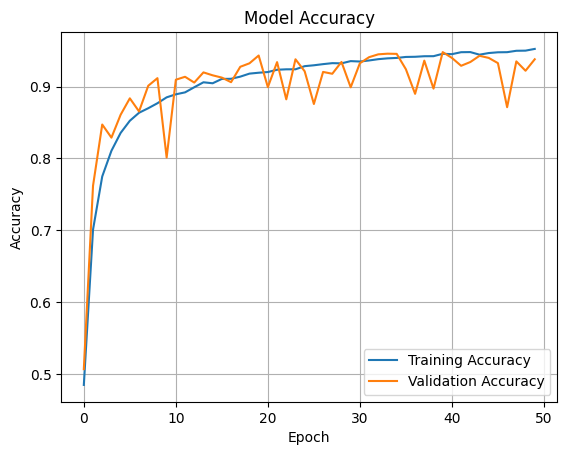

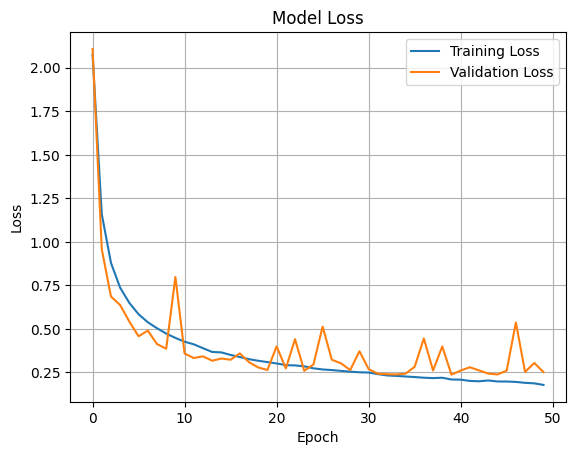

In [64]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training and validation loss in a different figure
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Part 6: Evaluation

Evaluate the model you have trained in Part 5 on the test data.

In [65]:
history = model.fit(test_images, test_labels, epochs=epochs)

Epoch 1/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7828 - loss: 0.9563
Epoch 2/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8384 - loss: 0.6007
Epoch 3/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8702 - loss: 0.4845
Epoch 4/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8845 - loss: 0.4265
Epoch 5/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8983 - loss: 0.3713
Epoch 6/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9024 - loss: 0.3376
Epoch 7/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9105 - loss: 0.3233
Epoch 8/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9223 - loss: 0.3015
Epoch 9/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9215 - loss: 0.2863
Epoch 10/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9218 - loss: 0.2687
Epoch 11/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9303 - loss: 0.2527
Epoch 12/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

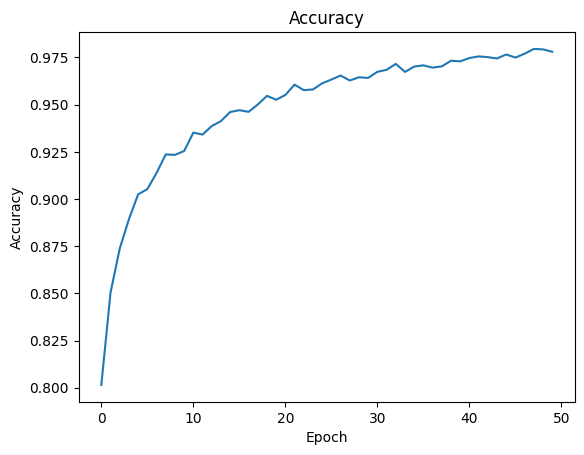

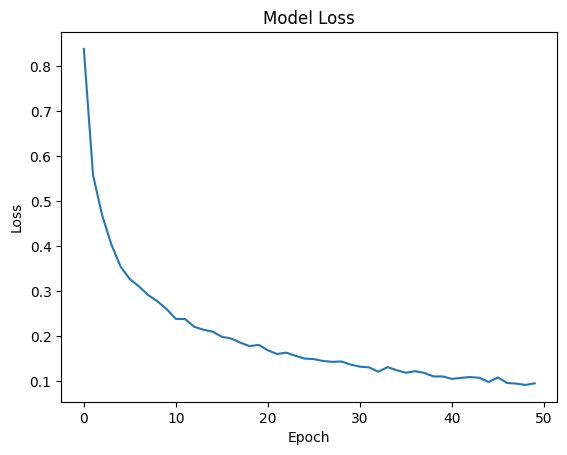

In [66]:
# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training and validation loss in a different figure
plt.figure()
plt.plot(history.history['loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


What is the final accuracy of your model?

Answer: ____97.71%____

Please summarize the characteristics of your model:

- Number of layers: 8 layers - 1 input, 1 output, 6 hidden
- Number of nodes per layer: 50 features per layer for hidden layers, 7500 for input, 43 for output
- Initialization: Glorot uniform initialization
- Activation Function: Linear and ReLu for hidden layers, softmax for output layer
- Normalization: Batch normalization
- Regularization: L2 and Dropout regularization
- Optimizer: Stochaistic Gradient Descent

In the following table, summarize the validation accuracy and running time during training for the different steps you have taken in the project. For parts, where you tried different models/parameters, report the one that you continued to use in later parts.

| Model                                 | validation accuracy | running time (per step) |
| ------------------------------------- | ------------------- |------------------------ |
| Baseline model in Part 1 (50/43)      | 48.67 %              | 5 ms                  |
| Your model in Part 1 (...)            | 52.68 %              | 7 ms                  |
| Activation function in Part 2         | 76.13 %              | 5 ms                  |
| Batch normalization in Part 3         | 82.24 %              | 8 ms                  |
| Regularization in Part 4              | 85.07 %              | 7 ms                  |

What do you observe about the running time when adding various features?

Answer: ____Choosing the proper activation function can significantly improve the performance of your model as well, as well as the right regularization techniques. However, batch normalization should be used carefully, as there is a performance overhead required with it's improved accuracy.____

Reflection: During this project, what worked as expected? Was there anything that surprised you? What did you learn?
    
Answer: ____It was interesting to see how the ordering of different layers resulted in different accuracies - although expected, as each layer influences the next, it still helps illustrate this concept with a demonstration. I was surprised to see the performance impact of each different step, from activation to regularization, as I had the impression that these were often comparable in performance overhead.____

____The most important thing I learned here was the importance of model design - choosing the best model features, from activation functions to regularization - on performance. Being able to see the tradeoffs between different methods and combinations was very helpful in developing the intuition for building and tuning machine learning models.____